In [2]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LogisticRegression

# Linear models

## Resources

Vincent Warmerdam: Winning with Simple, even Linear, Models PyData London 2018 - [youtube](https://www.youtube.com/watch?v=68ABAU_V8qI) - [slides](https://koaning.io/theme/notebooks/simple-models.pdf)

## Linear models

Good
- simple
- interpretable

Bad
- only linear relationships between feature & target
- no relationship between multiple features (such as if this, then that etc)

When to use linear models
- linear relationship between features & target
- when you have good features
- interpretability is important

Requirement of no-collinearity
- collinearity = correlation between features
- this cause instability of parameters -> can't interpret the parameters

We can use PCA with `whiten=True` to remove this:

In [3]:
from sklearn.decomposition import PCA

samples = 100
data = np.random.uniform(0, 1, size=samples)

dataset = np.vstack([
    data, 
    data + np.random.uniform(0, 0.5, size=samples),
    data - np.random.uniform(0, 0.5, size=samples)
]).T

assert dataset.shape[0] == samples

The covariance matrix shows collinearity:

In [4]:
np.corrcoef(dataset, rowvar=False)

array([[1.        , 0.91892866, 0.90879023],
       [0.91892866, 1.        , 0.83042668],
       [0.90879023, 0.83042668, 1.        ]])

We can use PCA to remove this:

In [5]:
tr = PCA(whiten=True)
clean = tr.fit_transform(dataset)
np.corrcoef(clean, rowvar=False)

array([[ 1.00000000e+00, -8.58167668e-17,  3.58859968e-17],
       [-8.58167668e-17,  1.00000000e+00, -3.93624527e-16],
       [ 3.58859968e-17, -3.93624527e-16,  1.00000000e+00]])

## Non-linear relationships with linear models

Clever feature engineering can allow you to solve non-linear problems with a linear model.

First create a dataset:

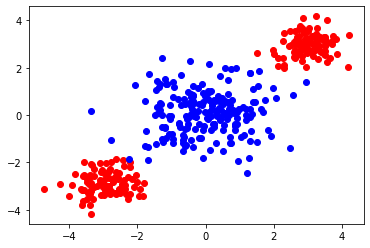

In [6]:
num_pts = 100

red_x = np.concatenate([np.random.normal(3, 0.5, num_pts), np.random.normal(-3, 0.5, num_pts)])
red_y = np.concatenate([np.random.normal(3, 0.5, num_pts), np.random.normal(-3, 0.5, num_pts)])

blue_x = np.concatenate([np.random.normal(0, 1, num_pts), np.random.normal(0, 1, num_pts)])
blue_y = np.concatenate([np.random.normal(0, 1, num_pts), np.random.normal(0, 1, num_pts)])

plt.scatter(red_x, red_y, color='red')
plt.scatter(blue_x, blue_y, color='blue')

We can show that a linear model works poorly:

In [7]:
features = np.zeros((num_pts*4, 2))
target = np.zeros((num_pts*4))

for idx, (x, y) in enumerate(zip(red_x, red_y)):
    features[idx, :] = x, y
    target[idx] = 0
    
for idx, (x, y) in enumerate(zip(blue_x, blue_y), idx):
    features[idx, :] = x, y
    target[idx] = 1
    
mdl = LogisticRegression(solver='lbfgs')

mdl.fit(features, target)

mdl.score(features, target)

0.53

Let's add a new feature:
- x1 * x2

In [8]:
features = np.concatenate(
    [features, 
     (features[:, 0] * features[:, 1]).reshape(-1, 1)], 
    axis=1
)

Now that we add this feature, our linear classifier does well:

In [9]:
mdl = LogisticRegression(solver='lbfgs')

mdl.fit(features, target)

mdl.score(features, target)

0.9925

## Radial basis functions

[Wikipedia](https://en.wikipedia.org/wiki/Radial_basis_function)

Class of functions where the value depends only on the distance between the input and a fixed point

There are a number of different kernels - we will focus on the Gaussian RBF kernel:

$$ r(x) = e^{-\epsilon (x-x_{0})^2}$$

where
- $\epsilon$ is a hyperparameter
- $x_{0}$ is the center

Let's try this on a real time series dataset - describes the minimum daily temperatures over 10 years (1981-1990) in the city Melbourne, Australia [from ML-mastery](https://machinelearningmastery.com/time-series-datasets-for-machine-learning/).

We will do year ahead prediction

In [ ]:
import pandas as pd

In [ ]:
data = pd.read_csv(
    'https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv', 
    index_col=0, parse_dates=True
)

data = data.iloc[-6*365:, :]

ax = data.plot()

A typical feature would be to use the month.

Let's train a simple linear model, with the month one-hot encoded:

In [ ]:
y = data.loc[:, 'Temp']
from sklearn.preprocessing import OneHotEncoder

from sklearn.linear_model import Ridge
enc = OneHotEncoder(sparse=False)
x = enc.fit_transform(data.index.month.values.reshape(-1, 1))

mdl = Ridge()
mdl.fit(x, y)

y_p = mdl.predict(x)

plt.plot(y)
plt.plot(y.index, y_p)

In [ ]:
from sklearn.metrics.pairwise import rbf_kernel

In [ ]:
days = np.arange(1, 365).reshape(-1, 1)

k = rbf_kernel(days, days, gamma=0.1)
print(k.shape)
plt.plot(k[128])

In [ ]:
rbf_data = data.copy()

days = rbf_data.index.dayofyear.values.reshape(-1, 1)
k = rbf_kernel(days, days, gamma=0.1)
plt.plot(k[5])

In [ ]:
for day in range(1, 365):
    rbf_data.loc[:, 'rbf{}'.format(day)] = k[day]
    
rbf_data.head()

In [ ]:
y = rbf_data.loc[:, 'Temp']
x = rbf_data.drop('Temp', axis=1)

mdl = Ridge()
mdl.fit(x, y)

y_p_r = mdl.predict(x)

f, a = plt.subplots(nrows=2, sharex=True, figsize=(20, 10))

a[0].plot(y, label='true', color='lightblue')
a[1].plot(y, label='true', color='lightblue')

a[0].plot(y.index, y_p, label='one-hot', color='black')
a[1].plot(y.index, y_p_r, label='rbf', color='black')

for ax in a:
    ax.legend()

## Feature selection with linear models

As we have a linear model, we can check to see which features are significant (note we need to use `statsmodels` to get this):

In [ ]:
import statsmodels.api as sm

ols = sm.OLS(y, x)
ols_result = ols.fit()
#ols_result.summary()

## Conversion of coordinates

class1 = np.

In [ ]:
from sklearn.datasets import make_circles

x, y = make_circles(factor=0.5)

plt.scatter(x[:, 0], x[:, 1], c=y)

In [ ]:
mdl = LogisticRegression(solver='lbfgs')
mdl.fit(x, y)
mdl.score(x, y)

https://stackoverflow.com/questions/20924085/python-conversion-between-coordinates

In [ ]:
def cartesian_to_polar(x, y):
    rho = np.sqrt(x**2 + y**2).reshape(-1, 1)
    phi = np.arctan2(y, x).reshape(-1, 1)
    return np.hstack([rho, phi])

xp = cartesian_to_polar(x[:, 0], x[:, 1])

mdl = LogisticRegression(solver='lbfgs')
mdl.fit(xp, y)
mdl.score(xp, y)

In [ ]:
plt.scatter(xp[:, 0], xp[:, 1], c=y)